In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##  Import necessary libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA

## Load Dataset

In [3]:
customers=pd.read_csv("/content/drive/MyDrive/Assig/Customers.csv")
products = pd.read_csv('/content/drive/MyDrive/Assig/Products.csv')
transactions = pd.read_csv('/content/drive/MyDrive/Assig/Transactions.csv')

# Data Cleaning and Preprocessing


In [4]:
# Merge customers and transactions on CustomerID
customer_transactions = pd.merge(customers, transactions, on='CustomerID', how='inner')

In [5]:
# Aggregate transaction data per customer
customer_data = customer_transactions.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'Quantity': 'sum',
    'Price': 'mean',
    'TransactionID': 'count'  # Number of transactions
}).reset_index()

In [6]:
# Add profile information (e.g., Region)
customer_data = pd.merge(customer_data, customers[['CustomerID', 'Region']], on='CustomerID', how='left')

In [7]:
# One-hot encode Region for clustering
customer_data = pd.get_dummies(customer_data, columns=['Region'], drop_first=True)

In [8]:
# Feature Scaling
scaler = StandardScaler()
features = customer_data.drop(columns=['CustomerID'])
scaled_features = scaler.fit_transform(features)

# Train Model

In [9]:
# Clustering
n_clusters = range(2, 11)
db_scores = []
silhouette_scores = []

for k in n_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(scaled_features)

    # Calculate Davies-Bouldin Index and Silhouette Score
    db_index = davies_bouldin_score(scaled_features, cluster_labels)
    silhouette_avg = silhouette_score(scaled_features, cluster_labels)

    db_scores.append(db_index)
    silhouette_scores.append(silhouette_avg)

In [10]:
# Optimal number of clusters based on DB Index
optimal_k = n_clusters[np.argmin(db_scores)]
print(f"Optimal number of clusters (based on DB Index): {optimal_k}")

Optimal number of clusters (based on DB Index): 10


In [11]:
# Final Clustering with optimal number of clusters
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42)
customer_data['Cluster'] = kmeans_final.fit_predict(scaled_features)

# Add cluster labels to original data
customer_data['Cluster'] = kmeans_final.labels_

# Visualization

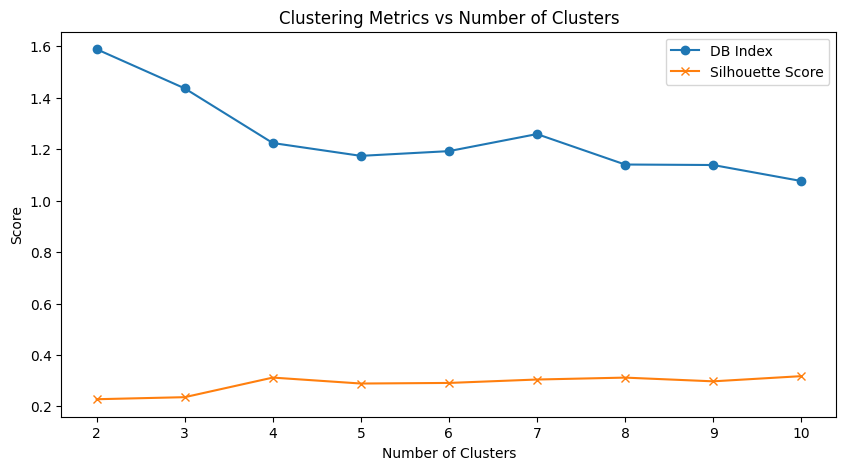

In [12]:
# Visualize DB Index and Silhouette Scores
plt.figure(figsize=(10, 5))
plt.plot(n_clusters, db_scores, marker='o', label='DB Index')
plt.plot(n_clusters, silhouette_scores, marker='x', label='Silhouette Score')
plt.title('Clustering Metrics vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.legend()
plt.show()

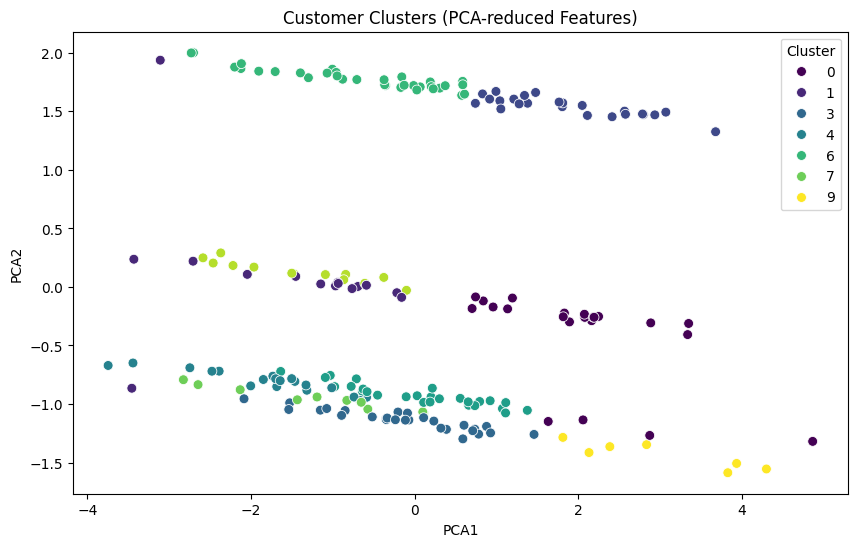

In [13]:
# Visualize clusters using PCA
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(scaled_features)
customer_data['PCA1'] = reduced_features[:, 0]
customer_data['PCA2'] = reduced_features[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=customer_data, x='PCA1', y='PCA2', hue='Cluster', palette='viridis', s=50)
plt.title('Customer Clusters (PCA-reduced Features)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster')
plt.show()

In [14]:
# Save clustering results
customer_data.to_csv('Customer_Clusters.csv', index=False)


In [15]:
# Print final metrics
final_db_index = davies_bouldin_score(scaled_features, customer_data['Cluster'])
print(f"Final DB Index: {final_db_index}")

final_silhouette_score = silhouette_score(scaled_features, customer_data['Cluster'])
print(f"Final Silhouette Score: {final_silhouette_score}")

Final DB Index: 1.0764163704326553
Final Silhouette Score: 0.31743171206716236
